In [26]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tqdm.notebook import tqdm, trange
from tensorflow.keras.layers import Dense, InputLayer
from sklearn.utils import shuffle
sns.set()
tf.keras.backend.floatx()

'float32'

In [2]:
n_mixtures = 3

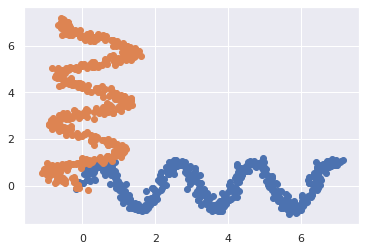

In [3]:
x = np.linspace(0, 7, 500, dtype=np.float32)
y = np.sin(3 * x)
x += np.random.normal(scale=0.1, size=x.shape)
y += np.random.normal(scale=0.1, size=y.shape)
plt.scatter(x, y)

angle = 1.5
rotatation = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
xy = np.array([x, y]).T @ rotatation
x, y = xy[:, 0].astype(np.float32), xy[:, 1].astype(np.float32)
plt.scatter(x, y)

In [62]:
class MDN(tf.keras.Model):
    def __init__(self, n_mixtures):
        super(MDN, self).__init__()
        
        self.n_mixtures = n_mixtures
        self.network = tf.keras.Sequential(layers=[
            InputLayer(input_shape=(1,)),
            Dense(100, activation='tanh'),
            Dense(50, activation='tanh'),
            Dense(3 * n_mixtures),
        ])
        
    def predict_distribution(self, x):
        mean, log_std, alpha = tf.split(self.network(x), 3, axis=1)
        alpha = tf.nn.softmax(alpha, axis=-1)
        return mean, log_std, alpha
    
    def sample(self, x, temperature=1.0, verbose=False):
        # Predicting distribution
        mean, log_std, alpha = self.predict_distribution(x)
        std = tf.exp(log_std) * np.sqrt(temperature)
        alpha = tf.nn.softmax(alpha / temperature, axis=-1)
        
        # Picking component
        rnd = tf.random.uniform(shape=[x.shape[0], 1], maxval=1)
        rnd = tf.repeat(rnd, self.n_mixtures, axis=-1)
        pdf = tf.cumsum(alpha, axis=-1)
        component_idx = np.argmax(pdf > rnd, axis=-1)
        
        # Gathering std and mean
        idx_flattened = tf.range(0, mean.shape[0]) * mean.shape[1] + component_idx
        component_std = tf.gather(tf.reshape(std, [-1]), idx_flattened)
        component_mean = tf.gather(tf.reshape(mean, [-1]), idx_flattened)

        # Sampling
        samples = tf.random.normal(shape=[x.shape[0]])
        samples = samples * component_std + component_mean
        return samples
    
    def call(self, x):
        return self.sample(x)

In [63]:
# def gaussian_loglikelihood(x, mu, log_std):
#     epsilon = 1e-8
#     pre_sum = -0.5 * (((x - mu) / (tf.exp(log_std) + epsilon))**2 + 2 * log_std + np.log(2 * np.pi))
#     return tf.reduce_sum(pre_sum, axis=-1)

def gaussian_pdf(x, mu, sigmasq):
    return (1 / tf.sqrt(2 * np.pi * sigmasq)) * tf.exp((-1 / (2 * sigmasq)) * (x - mu) ** 2)

def loss_fn(model, x, y_true):
    mean, log_std, alpha = model.predict_distribution(x)
    std = tf.exp(log_std) + 0.000001
    prob_sum = 0
    for i in range(model.n_mixtures):
        prob = gaussian_pdf(y_true, mean[:, i], std[:, i])
        prob_sum += prob * alpha[:, i]

    log_prob_sum = tf.reduce_mean(-tf.math.log(prob_sum))
    return log_prob_sum

In [64]:
def train(model):
    @tf.function()
    def gradient_step(model, x, y_true, optimizer):
        with tf.GradientTape() as tape:
            loss = loss_fn(model, x, y_true)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    @tf.function
    def fit(model, x, y, optimizer):
        x, y = tf.identity(x), tf.identity(y)
        idx = tf.random.shuffle(tf.range(len(x)))
        x = tf.gather(x, idx)
        y = tf.gather(y, idx)
        for j in range(len(x) // batch_size):
            loss = gradient_step(mdn, 
                                 x[j * batch_size: (j + 1) * batch_size, np.newaxis], 
                                 y[j * batch_size: (j + 1) * batch_size], 
                                 optimizer)
        return loss
    
    batch_size = 128
    optimizer = tf.keras.optimizers.Adam(5e-3)
    t = trange(1000)
    for i in t:
        loss = fit(model, x, y, optimizer)
        t.set_description('%.2f' % loss.numpy())

In [65]:
def plot(model):
    plt.figure(figsize=[16, 6])
    plt.subplot(1, 2, 1)
    every_n = 1
    y_pred = model.sample(x[::every_n, np.newaxis], temperature=1)

    plt.scatter(x, y)
    plt.scatter(x[::every_n], y_pred)
    plt.gca().set_xlim([-1.1, 1.6])
    plt.gca().set_ylim([-1, 8])

    plt.subplot(1, 2, 2)
    mean, _, alpha = model.predict_distribution(x[:, np.newaxis])

    plt.scatter(x, y, alpha=0.5)
    for component_idx in range(mdn.n_mixtures):
        component_mean = mean[:, component_idx]
        plt.plot(x, component_mean, alpha=0.7, label=component_idx)
    plt.gca().set_xlim([-1.1, 1.6])
    plt.gca().set_ylim([-1, 8])

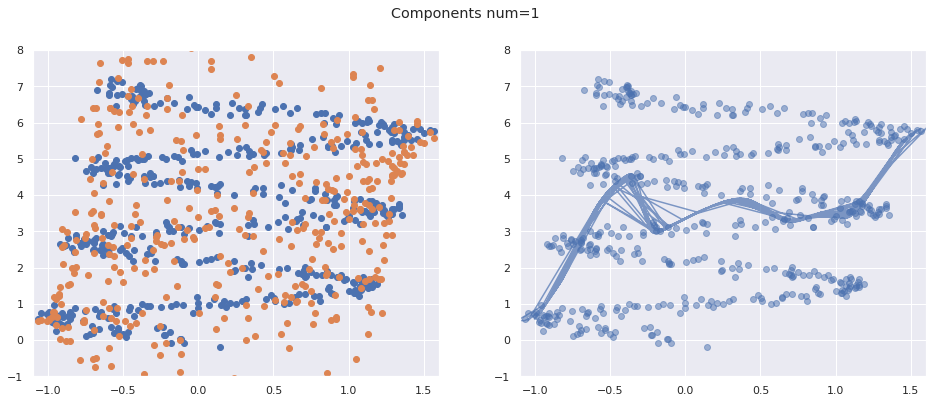

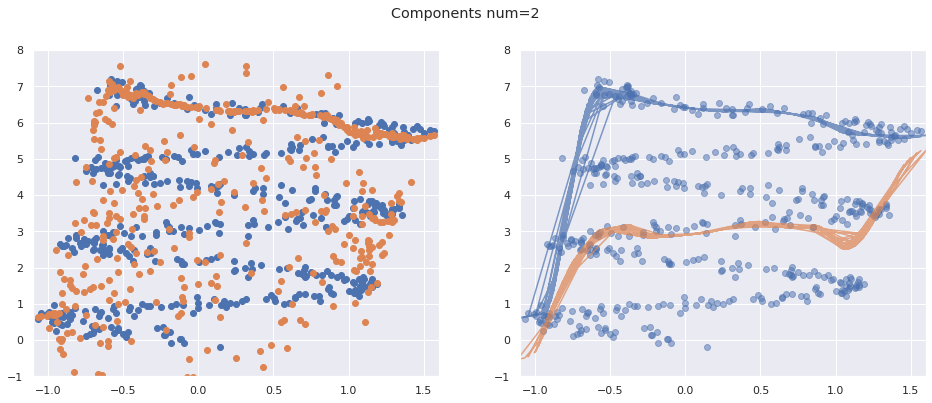

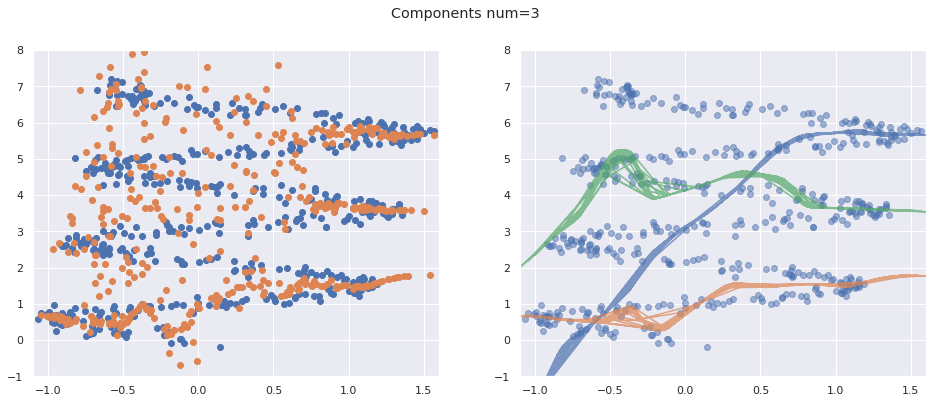

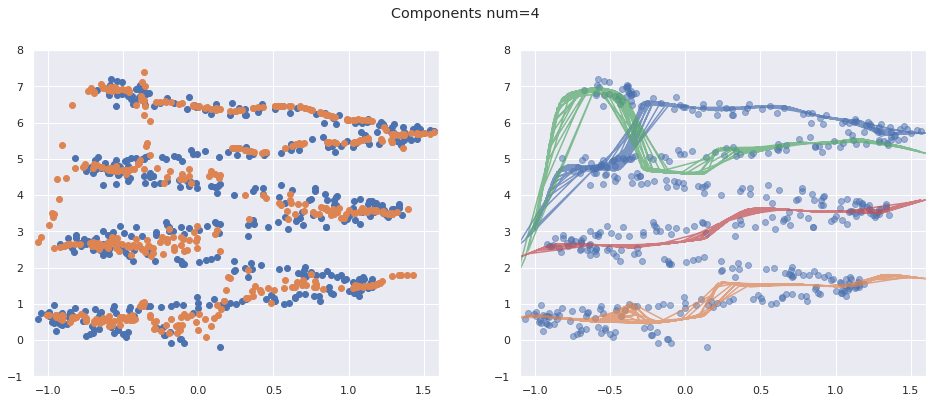

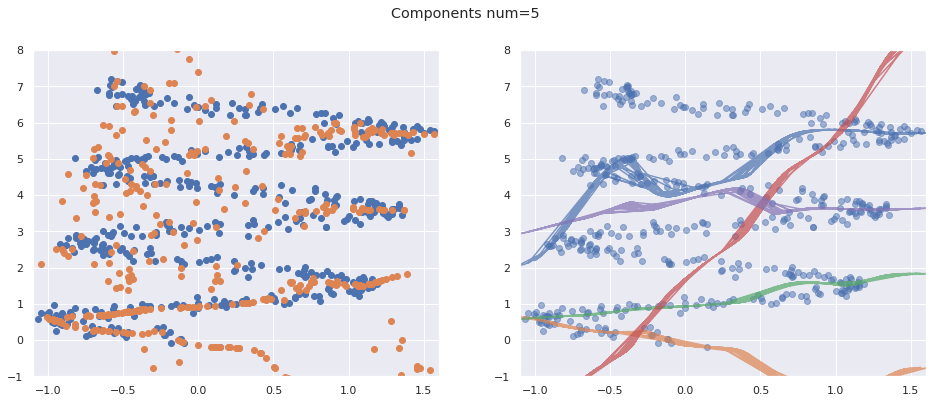

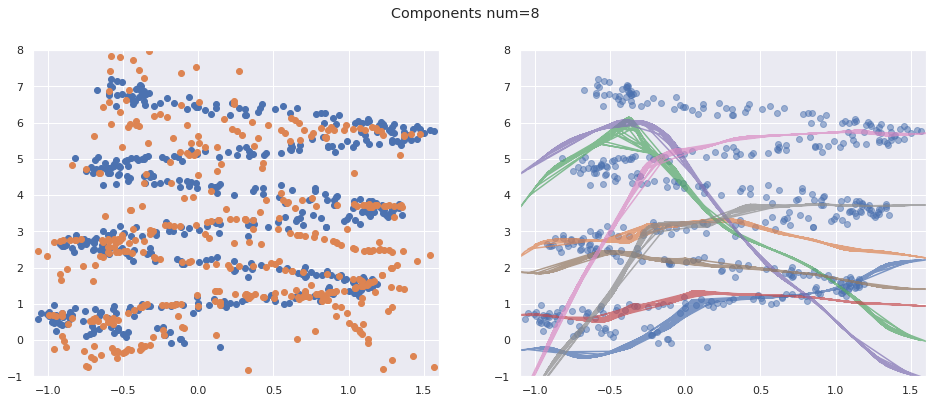

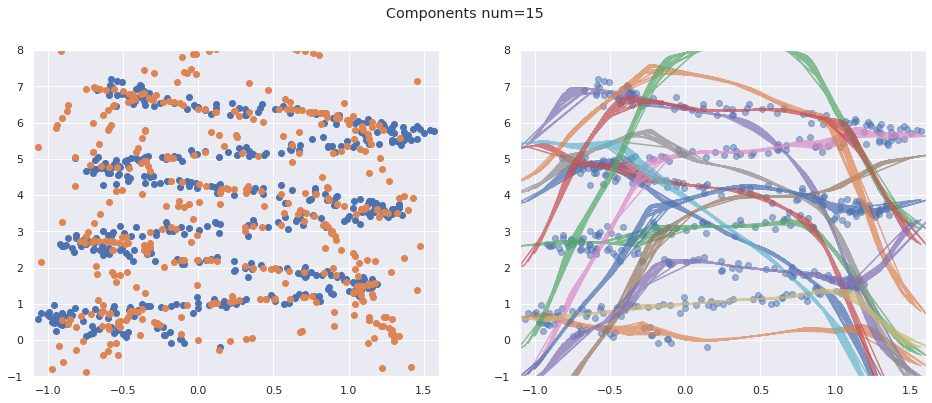

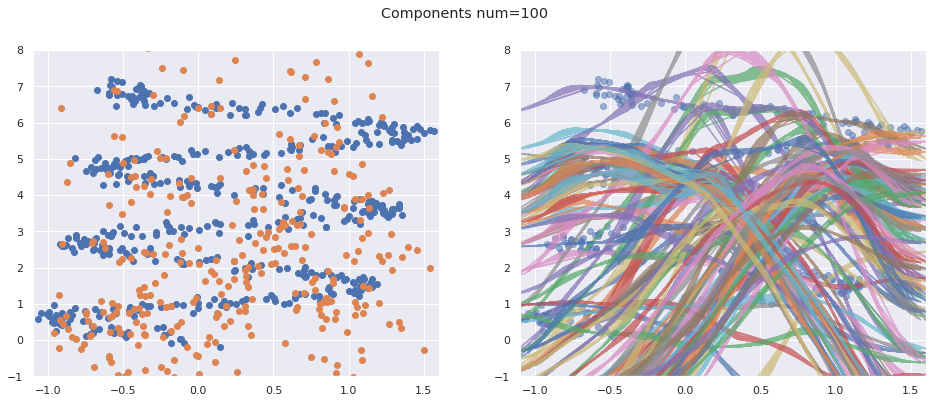

In [66]:
mdn = 0
for n_mixtures in [1, 2, 3, 4, 5, 8, 15, 100]:
    mdn = MDN(n_mixtures)
    train(mdn)
    plot(mdn)
    plt.suptitle(f'Components num={n_mixtures}')
    del mdn

In [ ]:
m, s, a = mdn.predict_distribution(x[:, np.newaxis])
a

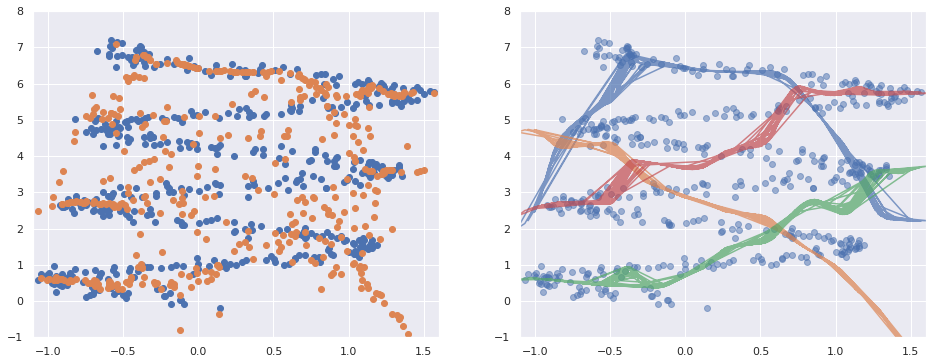

In [69]:
mdn = MDN(4)
train(mdn)
plot(mdn)

In [ ]:
# del plt
%matplotlib agg
import matplotlib.pyplot as plt

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)
@tf.function()
def gradient_step(model, x, y_true, optimizer):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, x, y_true)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

mdn = MDN(100)

t = trange(1000)
for i in t:
    loss = gradient_step(mdn, x[:, np.newaxis], y, optimizer)
    t.set_description('%.2f' % loss.numpy())
    plot(mdn)
    plt.savefig(f'gif/%.3d_pic.jpg' % i)

In [ ]:
!ffmpeg -i gif/%3d_pic.jpg anim.gif -y

In [ ]:
from IPython.display import Image
Image(filename="anim.gif")